This notebook uses a Pistachio Image data set found on Kaggle

https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset

The archive was downloaded and uploaded to Colab to the content folder

Extract using zipfile

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from numpy.random import seed
import zipfile
import os
import cv2
from sklearn.model_selection import train_test_split

seed(1234)
tf.random.set_seed(1234)

zip_ref = zipfile.ZipFile('/content/images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

x = []
y = []

class_label_encoding = {
    'Kirmizi_Pistachio': 0,
    'Siirt_Pistachio': 1
}
parent_dir = '../content/Pistachio_Image_Dataset/Pistachio_Image_Dataset/'

for directory in os.listdir(parent_dir):
    if('.txt' in directory): continue
    for file in os.listdir(parent_dir+'/'+directory):
        image_path = parent_dir+'/'+directory+'/'+file
        img = cv2.imread(image_path,0).astype('float32')
        img = cv2.resize(img, (244, 244), interpolation = cv2.INTER_AREA)
        img = cv2.merge((img, img, img))
        img/=255.
        x.append(img)
        y.append(class_label_encoding[directory])

x = np.array(x)
y = np.array(y)

x = x.reshape(x.shape[0], x.shape[1], x.shape[2],3)
x.shape

(2148, 244, 244, 3)

Train-Test Split
80% Train, 20% Test

Additional splits to make a smaller data set to try to stop RNN and transfer to stop crashing Colab

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1234, stratify=y)
x_train_small, x_test_small, y_train_small, y_test_small = train_test_split(x_test, y_test, test_size=0.2, random_state=1234, stratify=y_test)
x_train_smaller, x_test_smaller, y_train_smaller, y_test_smaller = train_test_split(x_test_small, y_test_small, test_size=0.2, random_state=1234, stratify=y_test_small)

Distribution Graph and Description

The data set contains images of pistachios grouped into two different kinds; Siirt and Kirmizi. The distribution of the data is not perfectly even but there isn't an extreme difference. The goal is for the model to predict which kind of pistachio the image shows.

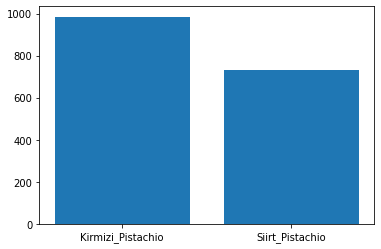

In [9]:
import matplotlib.pyplot as plt
vals = [y_train.shape[0] - y_train.sum(),y_train.sum()]
labels = ['Kirmizi_Pistachio','Siirt_Pistachio']
plt.bar(labels, vals)
plt.show()

Sequential Model

In [10]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import layers

model = keras.Sequential()
model.add(layers.Flatten(input_shape=(244, 244,3)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer = "adam",metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=50, verbose=1, callbacks=[EarlyStopping(patience=8,restore_best_weights=True)])


Epoch 1/50
14/14 [==============================] - 6s 380ms/step - loss: 10.2283 - accuracy: 0.6618 - val_loss: 1.5557 - val_accuracy: 0.8140
Epoch 2/50
14/14 [==============================] - 6s 413ms/step - loss: 0.9152 - accuracy: 0.7445 - val_loss: 0.4650 - val_accuracy: 0.7651
Epoch 3/50
14/14 [==============================] - 5s 379ms/step - loss: 0.5023 - accuracy: 0.7235 - val_loss: 0.4413 - val_accuracy: 0.8233
Epoch 4/50
14/14 [==============================] - 5s 345ms/step - loss: 0.4781 - accuracy: 0.7119 - val_loss: 0.4154 - val_accuracy: 0.8163
Epoch 5/50
14/14 [==============================] - 5s 365ms/step - loss: 0.4624 - accuracy: 0.7451 - val_loss: 0.4225 - val_accuracy: 0.8140
Epoch 6/50
14/14 [==============================] - 5s 391ms/step - loss: 0.4491 - accuracy: 0.7619 - val_loss: 0.4184 - val_accuracy: 0.8116
Epoch 7/50
14/14 [==============================] - 5s 336ms/step - loss: 0.4702 - accuracy: 0.7887 - val_loss: 0.4443 - val_accuracy: 0.8000
Epoch

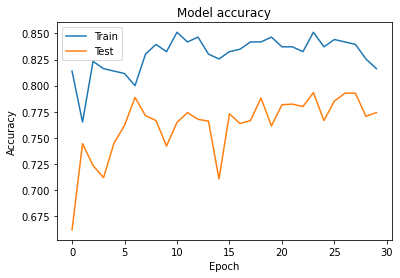

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3759632408618927
Test accuracy: 0.8372092843055725


Different architecture

In [13]:
model2 = keras.Sequential()
model2.add(layers.Flatten(input_shape=(244, 244,3)))
model2.add(layers.Embedding(1000, 64))
model2.add(layers.SimpleRNN(64))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',optimizer = "adam",metrics=['accuracy'])
#history = model2.fit(x_train_smaller, y_train_smaller, validation_data=(x_test_smaller, y_test_smaller), batch_size=32, epochs=5, verbose=1, callbacks=[EarlyStopping(patience=8,restore_best_weights=True)])

Pretrained

In [17]:
from keras.applications.vgg16 import VGG16

model3 = VGG16(
      input_shape = (244,244,3),
      include_top = False,
      weights = 'imagenet'
    )

from keras.layers import  Dropout
from keras.layers import  Flatten
x = Flatten()(model3.output)
x = Dropout(0.5)(x)
x = Dense(1, activation = "sigmoid")(x)

model3 = keras.Model(model3.input, x)
model3.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")
history3 = model3.fit(x_train_smaller, y_train_smaller, validation_data=(x_test_smaller, y_test_smaller), batch_size=128, epochs=10, verbose=1, callbacks=[EarlyStopping(patience=8,restore_best_weights=True)])

Epoch 1/10
1/1 [==============================] - 151s 151s/step - loss: 0.7904 - accuracy: 0.4853 - val_loss: 1.2921 - val_accuracy: 0.5556
Epoch 2/10
1/1 [==============================] - 164s 164s/step - loss: 1.3091 - accuracy: 0.5735 - val_loss: 0.6899 - val_accuracy: 0.5556
Epoch 3/10
1/1 [==============================] - 153s 153s/step - loss: 0.6944 - accuracy: 0.5147 - val_loss: 2.0376 - val_accuracy: 0.5556
Epoch 4/10
1/1 [==============================] - 160s 160s/step - loss: 2.1021 - accuracy: 0.5588 - val_loss: 0.7123 - val_accuracy: 0.4444
Epoch 5/10
1/1 [==============================] - 157s 157s/step - loss: 0.6866 - accuracy: 0.5735 - val_loss: 1.0989 - val_accuracy: 0.5556
Epoch 6/10
1/1 [==============================] - 156s 156s/step - loss: 1.1717 - accuracy: 0.5147 - val_loss: 0.7077 - val_accuracy: 0.4444
Epoch 7/10
1/1 [==============================] - 156s 156s/step - loss: 0.7551 - accuracy: 0.4559 - val_loss: 0.6876 - val_accuracy: 0.5556
Epoch 8/10
1/

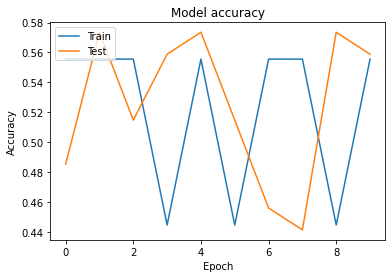

In [18]:
plt.plot(history3.history['val_accuracy'])
plt.plot(history3.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
score2 = model3.evaluate(x_test_smaller, y_test_smaller, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Test loss: 0.8184123039245605
Test accuracy: 0.5555555820465088


Analysis

I was not able to get RNN to work so it was commented out. The closest I got was one epoch with an estimated completion time of 20 minutes while the rest of the attempts crashed Colab. I got transfer to run, however it was very slow even on a smaller subset of the data so I only did 10 epochs. The accurary at the end was in the 50's suggesting that it did not learn anything and was no better than flipping a coin. Sequential did work and achieved an accuracy in the low 80's even with my limited knowledge and was fast in comparison to the others. I made a lot of mistakes and one of them is probably the way that the data was input. The difference in run time between sequential and the rest probably means the data was not efficiently input as even simplernn with only a few layers didn't work. Overall neural networks seem very vague with only a few loose best practices to guide you and seems to have a lot of trial and error. Long learning times mean that mistakes are very costly and made experimenting feel discouraging. 